# Model in this notebook

We solve a one-period sovereign debt model with exogenous IMF lending policy. The IMF loan is given by a state-dependent rule `l(g, eps)` at gross rate `R_l`. The government chooses next-period private debt `b'` (via issuance `n`) and can default.

**Repayment value:**

$$
v^{nd}(b,g,\epsilon) = \max_{c,n} \left\{ \frac{c^{1-\gamma}}{1-\gamma} + \beta g^{1-\gamma} E\left[\max\{v^{nd}(b',g',\epsilon'), v^{d}(b',g',\epsilon')\} \mid g\right] \right\}\
$$

$$
c + b = y + n + (1-R_l)l(g,\epsilon),\quad g b' = R(n,g) n,\quad y = g e^{\sigma\epsilon}.
$$

**Default value:**

$$
v^{d}(b,g,\epsilon) = \frac{(\phi(g) y)^{1-\gamma}}{1-\gamma} + \beta g^{1-\gamma} E\left[ \theta v^{d}(b',g',\epsilon') + (1-\theta) \max\{v^{nd}(\kappa b',g',\epsilon'), v^{d}(b',g',\epsilon')\} \mid g \right],
$$
$$
g b' = b.
$$
Prices follow `Q(b,g,eps) = (1-d) + d X` with `X` defined by the recovery equation, and `R(n,g)` is obtained from the pricing schedule.

In [63]:
using LinearAlgebra, Statistics
include("src/structs.jl")
include("src/utils.jl")
include("src/solver.jl")
include("src/simulation.jl")


summarize_simulation (generic function with 1 method)

In [64]:
# Initialize model with default parameters and grids
model = init_model()


Model(3000, 2, 17, [-0.05, -0.04969989996665555, -0.0493997999333111, -0.04909969989996665, -0.04879959986662221, -0.04849949983327776, -0.04819939979993331, -0.04789929976658886, -0.04759919973324441, -0.04729909969989997  …  0.8472990996998999, 0.8475991997332444, 0.8478992997665888, 0.8481993997999333, 0.8484994998332778, 0.8487995998666222, 0.8490996998999667, 0.849399799933311, 0.8496998999666555, 0.85], [0.96, 1.04], [-2.5, -2.1875, -1.875, -1.5625, -1.25, -0.9375, -0.625, -0.3125, 0.0, 0.3125, 0.625, 0.9375, 1.25, 1.5625, 1.875, 2.1875, 2.5], [0.6 0.4; 0.25 0.75], [0.009545481536386161, 0.011569338781329123, 0.021715131384701863, 0.036994999118988146, 0.05720736848350634, 0.08029541637317406, 0.10229643583903195, 0.11829381167458755, 0.12416403361658973, 0.11829381167458755, 0.10229643583903196, 0.08029541637317396, 0.05720736848350641, 0.03699499911898817, 0.02171513138470181, 0.011569338781329139, 0.009545481536386121], 0.55, 2.0, 0.023, 0.01, 0.1, 0.75, [0.985, 0.9], [1.0, 1.

In [65]:
sol = solve_model(model)
mean(sol.d)


0.21598039215686274

In [66]:
# Diagnostics: iteration counts, errors, and per-iteration timing
println("Outer iterations: ", sol.outer_iters)
println("Final outer error: ", sol.outer_errs[end])

for i in 1:sol.outer_iters
    println("iter=", i,
        ", vnd_err=", sol.outer_errs[i],
        ", vd_err=", sol.vd_errs[i],
        ", x_err=", sol.x_errs[i],
        ", vd_iters=", sol.vd_iters[i],
        ", x_iters=", sol.x_iters[i],
        ", time_s=", sol.outer_times[i])
end


Outer iterations: 61
Final outer error: 9.255357773518824e-7
iter=1, vnd_err=0.5944772311627606, vd_err=2.3961236728098356e-7, x_err=6.182905528673288e-7, vd_iters=7, x_iters=8, time_s=7.649222135543823
iter=2, vnd_err=0.15932740917923383, vd_err=1.2055553355594384e-7, x_err=9.835727174944964e-7, vd_iters=6, x_iters=18, time_s=2.7435970306396484
iter=3, vnd_err=0.04136663749254055, vd_err=3.8778432775998795e-7, x_err=5.860987399852746e-7, vd_iters=5, x_iters=9, time_s=1.9618699550628662
iter=4, vnd_err=0.018026233847539874, vd_err=1.8637362853013428e-7, x_err=7.097751258955398e-7, vd_iters=5, x_iters=6, time_s=1.7251129150390625
iter=5, vnd_err=0.0050029887964520015, vd_err=1.7200421176255531e-7, x_err=1.4082785781965867e-7, vd_iters=6, x_iters=6, time_s=4.04935097694397
iter=6, vnd_err=0.002567026987024157, vd_err=6.052389300847949e-7, x_err=7.463492039949671e-7, vd_iters=7, x_iters=11, time_s=5.7513439655303955
iter=7, vnd_err=0.0050983878244537095, vd_err=6.961317620124419e-7, x_err

In [67]:
sol = solve_model(model; sol = sol)    # reuse vnd/vd if non-empty
mean(sol.d)

0.21598039215686274

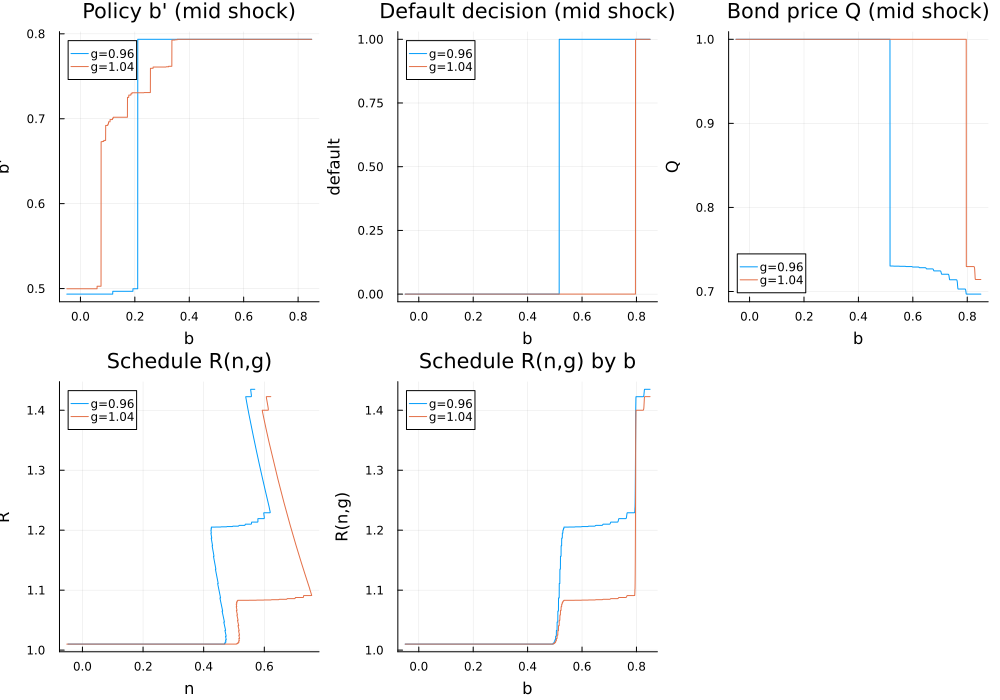

In [68]:
using Plots
b = model.b
g = model.g
eps = model.eps
e_idx = Int(cld(model.Ne, 2))
p1 = plot(title = "Policy b' (mid shock)", xlabel = "b'", ylabel = "b'")
p2 = plot(title = "Default decision (mid shock)", xlabel = "b'", ylabel = "default")
p3 = plot(title = "Bond price Q (mid shock)", xlabel = "b'", ylabel = "Q")
p4 = plot(title = "Schedule R(n,g)", xlabel = "n", ylabel = "R")
p5 = plot(title = "Schedule R(b',g)", xlabel = "b'", ylabel = "R(n,g)")
for gi in 1:model.Ng
    bprime_policy = b[sol.b_policy_idx[:, gi, e_idx]]
    plot!(p1, b, bprime_policy, label = "g=$(g[gi])")
    plot!(p2, b, Float64.(sol.d[:, gi, e_idx]), label = "g=$(g[gi])")
    plot!(p3, b, sol.Q[:, gi, e_idx], label = "g=$(g[gi])")
    plot!(p4, sol.n[:, gi], sol.R[:, gi], label = "g=$(g[gi])")
    plot!(p5, b, sol.R[:, gi], label = "g=$(g[gi])")
end
plot(p1, p2, p3, p4, p5, layout = (2, 3), size = (1000, 700))


In [69]:
# Simulation
b0_idx = 1  # pick a savings grid point by index
sim = simulate(model, sol; T = 200_000, b0_idx = b0_idx, seed = 1234)


(b = [-0.05, 0.4934811603867956, 0.7935811937312437, 0.6201233744581527, 0.7935811937312437, 0.7935811937312437, 0.7935811937312437, 0.6201233744581527, 0.7935811937312437, 0.7935811937312437  …  0.85, 0.85, 0.85, 0.6639379793264422, 0.7935811937312437, 0.7935811937312437, 0.7935811937312437, 0.7935811937312437, 0.7935811937312437, 0.7935811937312437], y = [0.96, 0.9738996644863737, 0.9456, 1.0626685166576872, 1.025156940090484, 1.047501927757008, 0.912220873540593, 1.047501927757008, 1.047501927757008, 0.9662109128379893  …  0.9456, 0.912220873540593, 0.9802005039958236, 1.025156940090484, 1.032551799036786, 1.032551799036786, 1.032551799036786, 1.0105257228996967, 1.025156940090484, 1.0626685166576872], n = [0.46905139997160766, 0.6196335777754153, 0.0, 0.7563682443984974, 0.7563682443984974, 0.7563682443984974, 0.0, 0.7563682443984974, 0.7563682443984974, 0.0  …  0.0, 0.0, 0.0, 0.7563682443984974, 0.7563682443984974, 0.7563682443984974, 0.7563682443984974, 0.7563682443984974, 0.7563

In [70]:
# Moments
stats = summarize_simulation(sim, model; burnin = 10_000, nbins = 1000)

println("Default rate (episodes / periods): ", stats.default_rate)
println("Mean debt-to-GDP: ", stats.mean_b_to_gdp)
println("Mean issuance-to-GDP: ", stats.mean_n_to_gdp)
println("Mean credit spread (non-default): ", stats.mean_credit_spread, " (N=", stats.credit_spread_obs, ")")
println("Share at b_min: ", stats.share_b_min, ", share at b_max: ", stats.share_b_max)

stats.hist_edges
stats.hist_counts


Default rate (episodes / periods): 0.1503263157894737
Mean debt-to-GDP: 0.7834406600278254
Mean issuance-to-GDP: 0.43458135986736546
Mean credit spread (non-default): 0.08143067069843073 (N=113533)
Share at b_min: 0.0, share at b_max: 0.15014210526315788


1000-element Vector{Int64}:
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     ⋮
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
 28527

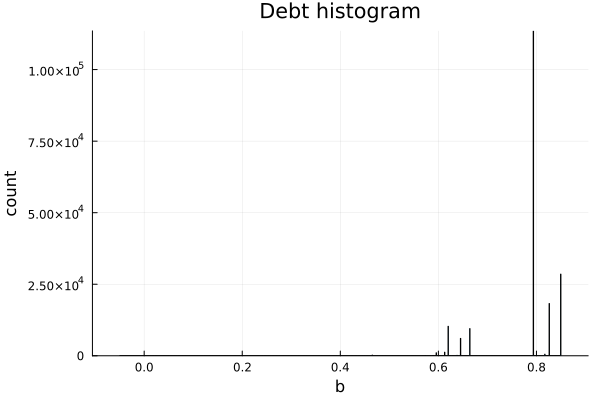

In [71]:
# Histogram of debt (b)
edges = stats.hist_edges
counts = stats.hist_counts
mid = 0.5 .* (edges[1:end-1] .+ edges[2:end])
bar(mid, counts; xlabel = "b", ylabel = "count", legend = false, title = "Debt histogram")


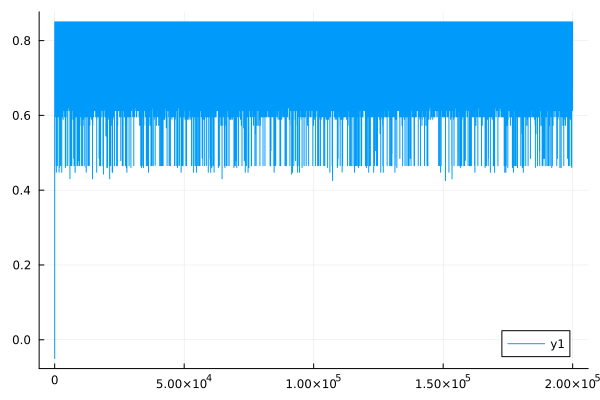

In [73]:
plot(sim.b)